In [1]:
import pandas as pd
import numpy as np
import gzip

import string
import itertools
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [11]:
ITEM_ID = 'beer/name'
USER_ID = 'user/profileName'
RATING = 'review/overall'
BINARY_RATING = 'Binary'
REVIEW_TEXT = 'review/text'
DATA_PATH = 'data/Beer/advocate/'
DATA_NAME = 'RefinedRawData.csv'

# Load Dataset

In [3]:
df = pd.read_csv(DATA_PATH+DATA_NAME, index_col=0)
df[REVIEW_TEXT] = df[REVIEW_TEXT].astype('str')
df[USER_ID] = df[USER_ID].astype('str')
df[ITEM_ID] = df[ITEM_ID].astype('str')
df.head()

/home/kai/.local/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,beer/ABV,beer/name,beer/style,review/overall,review/text,review/timeUnix,user/profileName
0,5.0,Sausa Weizen,Hefeweizen,1.5,A lot of foam. But a lot.\tIn the smell some b...,1234817823,stcules
1,6.2,Red Moon,English Strong Ale,3.0,"Dark red color, light beige foam, average.\tIn...",1235915097,stcules
2,6.5,Black Horse Black Beer,Foreign / Export Stout,3.0,"Almost totally black. Beige foam, quite compac...",1235916604,stcules
3,5.0,Sausa Pils,German Pilsener,3.0,"Golden yellow color. White, compact foam, quit...",1234725145,stcules
4,7.7,Cauldron DIPA,American Double / Imperial IPA,4.0,"According to the website, the style for the Ca...",1293735206,johnmichaelsen


In [4]:
len(df)

1586614

In [5]:
df[ITEM_ID].nunique()

56857

In [6]:
df = df[~df['user/profileName'].isnull()]

In [7]:
len(df)

1586614

In [8]:
df[USER_ID].nunique()

33388

In [12]:
def filter_dataset(df, threshold=3, popularity=True, filter_by_review_count=True, 
                   user_review_threshold=10, item_review_threshold=10, 
                   num_user=None, num_item=None, user_ratio=0.25, item_ratio=0.2):
    # Binarize rating
    df[BINARY_RATING] = (df[RATING] > threshold)*1

    # Filter dataset only based on positive ratings
    df = df[df[BINARY_RATING] == 1]
    
    print("The total number of users is {}".format(df[USER_ID].nunique()))
    print("The total number of items is {} \n".format(df[ITEM_ID].nunique()))
    

    values = df[ITEM_ID].value_counts().keys().tolist()
    counts = df[ITEM_ID].value_counts().tolist()
    item_df = pd.DataFrame.from_dict({ITEM_ID: values, "count": counts})
    
    values = df[USER_ID].value_counts().keys().tolist()
    counts = df[USER_ID].value_counts().tolist()
    user_df = pd.DataFrame.from_dict({USER_ID: values, "count": counts})
    
    if popularity:
        print("Filter dataset by popularity. \n")
        
        if filter_by_review_count:
            print("Filter dataset by review count. \n")
            
            filtered_item_df = item_df[item_df["count"] >= item_review_threshold]
            filtered_item_id = filtered_item_df[ITEM_ID].values
            
            filtered_user_df = user_df[user_df["count"] >= user_review_threshold]
            filtered_user_id = filtered_user_df[USER_ID].values
            
        else:
            print("Filter dataset by user and item number. \n")
            filtered_item_id = item_df[ITEM_ID].unique()[:num_item]
            filtered_user_id = user_df[USER_ID].unique()[:num_user]
            
    else:
        print("Filter dataset by sampling. \n")
        np.random.seed(8292)
        
        filtered_item_id = np.take(item_df[ITEM_ID].unique(), 
                                   indices=np.random.choice(len(item_df), int(item_ratio*len(item_df))))
        filtered_user_id = np.take(user_df[USER_ID].unique(), 
                                   indices=np.random.choice(len(user_df), int(user_ratio*len(user_df))))
        
    df = df.loc[(df[USER_ID].isin(filtered_user_id)) & (df[ITEM_ID].isin(filtered_item_id))]
    
    print("Number of User: {}".format(df[USER_ID].nunique()))
    print("Number of Item: {}".format(df[ITEM_ID].nunique()))

    return df

# Option1: Filter by popularity, then the number of users and items

In [32]:
filtered_df = filter_dataset(df, threshold=3, popularity=True, filter_by_review_count=False, 
                             user_review_threshold=None, item_review_threshold=None, 
                             num_user=40000, num_item=6000, user_ratio=None, item_ratio=None)

The total number of users is 31407
The total number of items is 50134 

Filter dataset by popularity. 

Filter dataset by user and item number. 

Number of User: 29477
Number of Item: 6000


# Option2: Filter by popularity, then the number of positive ratings of users and items

In [33]:
# filtered_df = filter_dataset(df, threshold=3, popularity=True, filter_by_review_count=True, 
#                              user_review_threshold=23, item_review_threshold=40, 
#                              num_user=None, num_item=None, user_ratio=None, item_ratio=None)

# Option3: Sample from the dataset

In [34]:
# filtered_df = filter_dataset(df, threshold=3, popularity=False, filter_by_review_count=False, 
#                              user_review_threshold=None, item_review_threshold=None, 
#                              num_user=None, num_item=None, user_ratio=0.25, item_ratio=0.7)

# Analyze the filtered dataset

In [35]:
filtered_df.head()

,beer/ABV,beer/name,beer/style,review/overall,review/text,review/timeUnix,user/profileName,Binary
17,7.4,Rauch Ür Bock,Rauchbier,4.5,Pours a murky light brown with a 1 inch fizzy ...,1325478004,UCLABrewN84,1
18,7.4,Rauch Ür Bock,Rauchbier,4.0,Faint sudsy head with some with some dissipati...,1325360812,zaphodchak,1
19,7.4,Rauch Ür Bock,Rauchbier,4.0,A new arrival to the West TN area... \t\tPours...,1322506304,Tilley4,1
20,7.4,Rauch Ür Bock,Rauchbier,4.5,Sampled 10/30/11 - Transferring the notes.\t\t...,1320494397,mikedrinksbeer2,1
21,7.4,Rauch Ür Bock,Rauchbier,4.0,This is my first rauchbier. \tPours a burnt am...,1320140421,dbmernin83,1


In [36]:
values = filtered_df[USER_ID].value_counts().keys().tolist()
counts = filtered_df[USER_ID].value_counts().tolist()
user_df = pd.DataFrame.from_dict({USER_ID: values, "count": counts})

values = filtered_df[ITEM_ID].value_counts().keys().tolist()
counts = filtered_df[ITEM_ID].value_counts().tolist()
item_df = pd.DataFrame.from_dict({ITEM_ID: values, "count": counts})

In [37]:
item_df.tail()

,beer/name,count
5995,Lhasa Beer,30
5996,Whittier White,30
5997,Sunspot IPA (Brewmaster Reserve),30
5998,Weissbier,30
5999,Red Mo Ale,30


In [38]:
item_df["count"].mean()

184.289

In [39]:
user_df[user_df["count"] >= 10]

,user/profileName,count
0,mikesgroove,3180
1,BuckeyeNation,2893
2,northyorksammy,2736
3,brentk56,2363
4,NeroFiddled,2275
5,oberon,2226
6,WesWes,2210
7,BEERchitect,2085
8,feloniousmonk,2063
9,russpowell,2047


In [40]:
users = user_df[user_df["count"] >= 10][USER_ID].values

In [41]:
pos_df = filtered_df.loc[filtered_df[USER_ID].isin(users)].reset_index(drop=True)
pos_df

# Export the filtered dataset

# pos_df.to_csv(DATA_PATH+DATA_NAME+".csv", header=False)

,beer/ABV,beer/name,beer/style,review/overall,review/text,review/timeUnix,user/profileName,Binary
0,7.4,Rauch Ür Bock,Rauchbier,4.5,Pours a murky light brown with a 1 inch fizzy ...,1325478004,UCLABrewN84,1
1,7.4,Rauch Ür Bock,Rauchbier,4.0,Faint sudsy head with some with some dissipati...,1325360812,zaphodchak,1
2,7.4,Rauch Ür Bock,Rauchbier,4.0,A new arrival to the West TN area... \t\tPours...,1322506304,Tilley4,1
3,7.4,Rauch Ür Bock,Rauchbier,4.5,Sampled 10/30/11 - Transferring the notes.\t\t...,1320494397,mikedrinksbeer2,1
4,7.4,Rauch Ür Bock,Rauchbier,4.0,This is my first rauchbier. \tPours a burnt am...,1320140421,dbmernin83,1
5,7.4,Rauch Ür Bock,Rauchbier,4.5,"A: Pours a rich, ruby color, clear. Maybe a fi...",1319847514,titosupertramp,1
6,7.4,Rauch Ür Bock,Rauchbier,5.0,"Pours a mahogany color, rich, with a tan head....",1318802642,optimator13,1
7,7.4,Rauch Ür Bock,Rauchbier,4.5,Pours light caramel brown with reddish highlig...,1318290101,Blakaeris,1
8,7.4,Rauch Ür Bock,Rauchbier,4.5,Poured a slightly cloudy deep amber/red color ...,1318289482,bashiba,1
9,7.4,Rauch Ür Bock,Rauchbier,4.5,Big thanks to N2168 for knocking this off my w...,1316405909,Klym,1


In [42]:
items = pos_df[ITEM_ID].values

# Get the final DF with reviews

In [43]:
cur_df = df.loc[(df[USER_ID].isin(users)) & (df[ITEM_ID].isin(items))].reset_index(drop=True)
cur_df

,beer/ABV,beer/name,beer/style,review/overall,review/text,review/timeUnix,user/profileName,Binary
0,7.4,Rauch Ür Bock,Rauchbier,4.5,Pours a murky light brown with a 1 inch fizzy ...,1325478004,UCLABrewN84,1
1,7.4,Rauch Ür Bock,Rauchbier,4.0,Faint sudsy head with some with some dissipati...,1325360812,zaphodchak,1
2,7.4,Rauch Ür Bock,Rauchbier,4.0,A new arrival to the West TN area... \t\tPours...,1322506304,Tilley4,1
3,7.4,Rauch Ür Bock,Rauchbier,4.5,Sampled 10/30/11 - Transferring the notes.\t\t...,1320494397,mikedrinksbeer2,1
4,7.4,Rauch Ür Bock,Rauchbier,4.0,This is my first rauchbier. \tPours a burnt am...,1320140421,dbmernin83,1
5,7.4,Rauch Ür Bock,Rauchbier,4.5,"A: Pours a rich, ruby color, clear. Maybe a fi...",1319847514,titosupertramp,1
6,7.4,Rauch Ür Bock,Rauchbier,5.0,"Pours a mahogany color, rich, with a tan head....",1318802642,optimator13,1
7,7.4,Rauch Ür Bock,Rauchbier,4.5,Pours light caramel brown with reddish highlig...,1318290101,Blakaeris,1
8,7.4,Rauch Ür Bock,Rauchbier,4.5,Poured a slightly cloudy deep amber/red color ...,1318289482,bashiba,1
9,7.4,Rauch Ür Bock,Rauchbier,4.5,Big thanks to N2168 for knocking this off my w...,1316405909,Klym,1


In [44]:
cur_df[USER_ID].nunique()

9226

In [45]:
cur_df[ITEM_ID].nunique()

6000

# Note: For CD dataset, just use the existing split

In [5]:
filtered_df = pd.read_csv('../NCE_Projected_LRec/data/amazon/raw/reviews_CDs_and_Vinyl_5.csv', 
                          names=[USER_ID, ITEM_ID, RATING, TIMESTAMP, REVIEW_TEXT, BINARY_RATING])

In [6]:
if filtered_df[USER_ID].nunique() == 6056 and filtered_df[ITEM_ID].nunique() == 4395:
    print("Filtered dataset check verified.")

Filtered dataset check verified.


In [7]:
users = filtered_df[USER_ID].unique()
items = filtered_df[ITEM_ID].unique()

In [8]:
len(users) == 6056

True

In [9]:
len(items) == 4395

True

In [10]:
cur_df = df.loc[(df[USER_ID].isin(users)) & (df[ITEM_ID].isin(items))].reset_index(drop=True)
cur_df

,reviewerID,asin,overall,unixReviewTime,reviewText
0,A2GANR9I6XHTU9,0780018664,4.0,1169337600,Filmed in 1931 this is the first serial killer...
1,ANCOMAI0I7LVG,0780018664,5.0,1213574400,My feelings for this iconic piece of filmmakin...
2,A1GGOC9PVDXW7Z,0780018664,5.0,1268524800,The title M comes from a chalk mark (for 'murd...
3,A62G4QX6XQVLP,0780018664,5.0,1165190400,This film is easily in the Top 5 of Fritz Lang...
4,A2ILOYARQVO4K1,0780018664,4.0,989193600,"Dark, disturbingly satirical, humorous exactly..."
5,A2XKQHB8VCUCJK,0780018664,5.0,1385942400,&#34;M&#34; is a German expressionist film dir...
6,AIMR915K4YCN,0780018664,5.0,1083196800,"While watching this story unfold, I found myse..."
7,A1GHUN5HXMHZ89,0780018664,5.0,1300406400,"I don't know if it is in writing somewhere, bu..."
8,A2C7BOQVFH1HLE,0780018664,4.0,1302825600,This is the first Criterion release that I've ...
9,A25FDX17O3QKLT,0780018664,5.0,1115769600,This famous Fritz Lang classic is about a chil...


# Preprocess Review

In [46]:
def preprocess(text):
#     text = text.replace('.',' ').replace('/',' ').replace('quot;', ' ').replace('amp;', '').replace('-', ' ')
    
    text = text.replace('.',' ').replace('/t',' ').replace('\t',' ')
    
    # Tokenize
    text = nltk.word_tokenize(text)
    
    # Lowercase
    text = [w.lower() for w in text]

    # Remove Punctuation
    table = str.maketrans('', '', string.punctuation)
    text = [w.translate(table) for w in text]

    # Remove tokens that are not alphabetic
    text = [w for w in text if w.isalpha()]

    # Remove Stopwords
    # Get english stopwords
    en_stopwords = set(stopwords.words('english'))
    text = [w for w in text if w not in en_stopwords]
    
#     # Lemmatizing
#     lemmatizer = WordNetLemmatizer()
#     text = [lemmatizer.lemmatize(w) for w in text]
    
#     # R&B
#     text = [x.replace("rb", " r b ") if x=="rb" else x for x in text]

#     text = " " + " ".join(str(x) for x in text) + " "
    
#     text = text.replace(' randb ', ' r b ').replace(' rnb ', ' r b ')
#     text = text.replace('hip hop', 'hiphop')
#     text = text.replace('classic rock', 'classicrock')
#     text = text.replace('hard rock', 'hardrock')
#     text = text.replace('country music', 'countrymusic')
#     text = text.replace('easy listen', 'easylisten')
#     text = text.replace('music video', 'musicvideo')
#     text = text.replace('new age', 'newage')
#     text = text.replace('alternative rock', 'alternativerock')
#     text = text.replace('spoken word', 'spokenword')

    
#     # Reset to token
#     text = nltk.word_tokenize(text)
#     table = str.maketrans('', '', string.punctuation)
#     text = [w.translate(table) for w in text]
#     text = [w for w in text if w.isalpha()]
#     en_stopwords = set(stopwords.words('english'))
#     text = [w for w in text if w not in en_stopwords]
#     lemmatizer = WordNetLemmatizer()
#     text = [lemmatizer.lemmatize(w) for w in text]
    
    return text
    
cur_df["review"] = cur_df[REVIEW_TEXT].apply(preprocess)
cur_df["conca_review"] = cur_df["review"].apply(lambda x: " " + " ".join(str(x) for x in x) + " ")

In [47]:
cur_df

,beer/ABV,beer/name,beer/style,review/overall,review/text,review/timeUnix,user/profileName,Binary,review,conca_review
0,7.4,Rauch Ür Bock,Rauchbier,4.5,Pours a murky light brown with a 1 inch fizzy ...,1325478004,UCLABrewN84,1,"[pours, murky, light, brown, inch, fizzy, tan,...",pours murky light brown inch fizzy tan head s...
1,7.4,Rauch Ür Bock,Rauchbier,4.0,Faint sudsy head with some with some dissipati...,1325360812,zaphodchak,1,"[faint, sudsy, head, dissipating, fine, surfac...",faint sudsy head dissipating fine surface lig...
2,7.4,Rauch Ür Bock,Rauchbier,4.0,A new arrival to the West TN area... \t\tPours...,1322506304,Tilley4,1,"[new, arrival, west, tn, area, pours, quite, b...",new arrival west tn area pours quite bit ligh...
3,7.4,Rauch Ür Bock,Rauchbier,4.5,Sampled 10/30/11 - Transferring the notes.\t\t...,1320494397,mikedrinksbeer2,1,"[sampled, transferring, notes, ruby, pour, hal...",sampled transferring notes ruby pour half fin...
4,7.4,Rauch Ür Bock,Rauchbier,4.0,This is my first rauchbier. \tPours a burnt am...,1320140421,dbmernin83,1,"[first, rauchbier, pours, burnt, amber, good, ...",first rauchbier pours burnt amber good head h...
5,7.4,Rauch Ür Bock,Rauchbier,4.5,"A: Pours a rich, ruby color, clear. Maybe a fi...",1319847514,titosupertramp,1,"[pours, rich, ruby, color, clear, maybe, finge...",pours rich ruby color clear maybe finger offw...
6,7.4,Rauch Ür Bock,Rauchbier,5.0,"Pours a mahogany color, rich, with a tan head....",1318802642,optimator13,1,"[pours, mahogany, color, rich, tan, head, fing...",pours mahogany color rich tan head finger nt ...
7,7.4,Rauch Ür Bock,Rauchbier,4.5,Pours light caramel brown with reddish highlig...,1318290101,Blakaeris,1,"[pours, light, caramel, brown, reddish, highli...",pours light caramel brown reddish highlights ...
8,7.4,Rauch Ür Bock,Rauchbier,4.5,Poured a slightly cloudy deep amber/red color ...,1318289482,bashiba,1,"[poured, slightly, cloudy, deep, amberred, col...",poured slightly cloudy deep amberred color th...
9,7.4,Rauch Ür Bock,Rauchbier,4.5,Big thanks to N2168 for knocking this off my w...,1316405909,Klym,1,"[big, thanks, knocking, wants, poured, stone, ...",big thanks knocking wants poured stone nonic ...


# Index Words since no further changes will be made on the words

In [48]:
tokenizer = Tokenizer()
token_list = cur_df["review"].tolist()
tokenizer.fit_on_texts(token_list)

In [49]:
df_word_index = pd.DataFrame(list(tokenizer.word_index.items()), columns=['word','index'])

In [50]:
df_word_index

,word,index
0,beer,1
1,head,2
2,taste,3
3,nice,4
4,good,5
5,malt,6
6,hops,7
7,light,8
8,sweet,9
9,like,10


In [51]:
token_flatten_list = [item for sublist in token_list for item in sublist]

In [52]:
total_token = len(token_flatten_list)
total_token

88059438

In [53]:
from nltk.probability import FreqDist

fdist1 = FreqDist(token_flatten_list)

In [54]:
fdist1.most_common(250)

[('beer', 1488119),
 ('head', 1235709),
 ('taste', 886127),
 ('nice', 853662),
 ('good', 796652),
 ('malt', 723402),
 ('hops', 722951),
 ('light', 711550),
 ('sweet', 688889),
 ('like', 675319),
 ('one', 637992),
 ('bit', 597607),
 ('carbonation', 593443),
 ('flavor', 582775),
 ('dark', 575271),
 ('nt', 545141),
 ('aroma', 538715),
 ('well', 519611),
 ('little', 511478),
 ('glass', 494035),
 ('color', 482049),
 ('bottle', 480183),
 ('smell', 479790),
 ('finish', 471191),
 ('mouthfeel', 458808),
 ('pours', 454559),
 ('lacing', 436284),
 ('hop', 424732),
 ('alcohol', 402751),
 ('body', 398087),
 ('brown', 390433),
 ('really', 383529),
 ('chocolate', 374387),
 ('caramel', 371966),
 ('poured', 364481),
 ('medium', 362768),
 ('much', 361737),
 ('white', 354231),
 ('would', 353136),
 ('great', 330450),
 ('malts', 325258),
 ('nose', 321880),
 ('smooth', 317831),
 ('notes', 316438),
 ('bitterness', 316170),
 ('flavors', 302338),
 ('citrus', 298596),
 ('bitter', 297765),
 ('sweetness', 285561),

In [19]:
fdist1['bass']

19700

In [20]:
len(cur_df[cur_df["conca_review"].str.contains('electro', regex=False)])

4934

In [21]:
cur_df[cur_df["conca_review"].str.contains('rockroll', regex=False)][REVIEW_TEXT].values[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [901]:
len(cur_df[cur_df[REVIEW_TEXT].str.contains('opera', regex=False)])

2169

In [990]:
cur_df[cur_df["conca_review"].str.contains('rockroll', regex=False)]["conca_review"].values[0]

' led zeppelin name alone pure rocknroll subject nt get much better late led zeppelin set standard rock music helped define sure didnt invent contributed largely success still remembered today accomplished many thing inducted rockroll hall fame four member robert plant vocal jimmy page guitarist john paul jones bassist john bonham drummer exceptional musician musical gift yet great album song band done hard really make compilation true led zeppelin mothership double disc set compilation covering band whole career unique package actually quite similar early latter day compilation took track added four track ramble heartbreaker hill far away dyer maker good addition simply enough already album already would suggest edition mothership dvd instead basically sample led zeppelin dvd already album dvd unnecessary yet amongst people yet hear led zeppelin fine decent price cover whole career nice might consider paying extra buck get edition come dvd specific edition dvd includes performance roy

In [45]:
# Lemmatizing
lemmatizer = WordNetLemmatizer()
# lemma_flat = [lemmatizer.lemmatize(w) for w in flat_list]

lemmatizer.lemmatize("operas")

'opera'

In [566]:
# for w in key:
#     if w != lemmatizer.lemmatize(w):
#         print("w is {}".format(w))
#         print("lemma is {}".format(lemmatizer.lemmatize(w)))
# # [lemmatizer.lemmatize(w) for w in key]

w is children
lemma is child


In [54]:
key = ["r b", "rock", "ballad", "metal", "chorus", "pop", "jazz", "indie", "classicrock", "hardrock", "countrymusic", 
       "folk", "rap", "hiphop", "classical", "christian", "gospel", "soundtrack", "dance", "electro", "blue", 
       "instrument", "musicvideo", "concert", "reggae", "vocalist", "opera ", "funk", "punk", "techno", "disco", 
       "psychedelic", "ambient", "progressive", "orchestra","industrial", "grunge", "chant", "drum", "bass"]
"soul", "house", 
#  ('alternativerock', 952),
#  ('easylisten', 945),
#  ('trance', 899),
#  ('broadway', 895),
#  ('brass', 826),
#  ('wedding', 670),
#  ('spokenword', 630),
#  ('newage', 580),
#  ('comedy', 451),
#  ('military', 234),
#  ('baroque', 193),
#  ('cabaret', 173)

('soul', 'house')

In [55]:
len(key)

40

In [56]:
fdist1['hiphop']

12470

In [845]:
cur_df[cur_df["conca_review"].str.contains('music video', regex=False)]["conca_review"].values[17]

' one major regret michael jackson often seemed success never manage spill silver screen way music star prince whitney houston presentation released closest ever got released bad tour huge period around success present mike artist interesting period transition course opposed one whole movie like series longer shorter others theme explored vignette tend child paranoia typical theme michael career general decade come first presented live rendition man mirror interspersed moving scene music video mike performance impassioned always ca nt help reminded weird idolizing seemed part undoing scene fan panting mere sight climbing fence whatnot one favorite part stop gap clay animation presentation mike early career brother reminder cgi widely available animation highly organic look find personally refreshing quirky extended video speed demon involving claymation bit awho framed roger rabbitflavor general focus sense intense paranoia situation addition music video leave alone course ultimate flo

In [759]:
cur_df[cur_df["conca_review"].str.contains('country', regex=False)][REVIEW_TEXT].values[17]

"...but it just seems to me that $$$$ is the driving force behind baby boomer, but particularly Beatles, reissues.  This has never been released on video, to my knowledge, so it is an event.  And it's nice to get the bonus stuff.  But I think the pricetag is out of line, priced too high just because they know they can get it.It just seems a shameless ripoff (kinda like gas prices).  I mean, these guys all donated their time, played for no pay, to benefit a country in need.  This kind of greedy, self-serving pricing seems at horrible odds with the original intent of the concert itself.  People say this was the Live Aid template.  The Live Aid DVD came out last March, a 4 DVD set that is priced at half of what this set is.Something's terribly wrong here."

In [625]:
cur_df[cur_df["conca_review"].str.contains('hardrock', regex=False)][REVIEW_TEXT].values[13]

'I remember when Aqualung was just released, and everybody had the album. It was extremely popular here in Denmark, along with &quot;Who`s Next&quot; and the Led Zeppelin and Ten Years After albums. It probably Tull`s most hard-rocking album, and at least at that time it was comsidered &quot;heavy&quot; rock.I saw them perform in Holstebro with new member John Evan - and it was really a great hard rocking performance; I was very impressed by guitarist Martin Barre.Songs like &quot;Locomotive Breath&quot; and &quot;Aqualung&quot; are great live rockers - but also very melodic.I never cared much for &quot;Cross-Eyed Mary&quot;, &quot;Hymn 43&quot; and &quot;Up to Me&quot;, but acoustic songs like &quot;Cheap Day Return&quot;, &quot;Mother Goose&quot; and &quot;Wondering Aloud&quot; and still favourites of mine.&quot;My God&quot; is too much an integrated part of the album-concept to be judged on its own.The highlight is the great finale &quot;Wind Up&quot;There are six bonus tracks.&quot

In [635]:
cur_df[cur_df["conca_review"].str.contains('heavymetal', regex=False)][REVIEW_TEXT].values[20]

105

# Define Bigram Right Type (ADJ/NN)

In [55]:
#function to filter for ADJ/NN bigrams
def filter_type(ngram):
    if '-pron-' in ngram or 't' in ngram:
        return False
    for word in ngram:
        if word.isspace():
            return False
    acceptable_types = ('JJ', 'JJR', 'JJS')
    ins = ('IN','TO')
    second_type = ('NN', 'NNS', 'NNP', 'NNPS')
    tags = nltk.pos_tag(ngram)
    
    if len(tags) == 2:
        if tags[0][1] in acceptable_types and tags[1][1] in second_type:
            return True
        else:
            return False
    elif len(tags) == 3:
        if tags[0][1] in acceptable_types and tags[1][1] in ins and tags[2][1] in second_type:
            return True
        else:
            return False
    else:
        if tags[0][1] in acceptable_types and tags[1][1] in ins and tags[2][1] in acceptable_types and tags[3][1] in second_type:
            return True
        else:
            return False 

# Bigram

In [56]:
bigrams = nltk.collocations.BigramAssocMeasures()
tokens = itertools.chain.from_iterable(token_list)
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
bigramFinder.apply_freq_filter(100)

bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), 
                               columns=['ngram','freq']).sort_values(by='freq', ascending=False)

In [57]:
bigramFreqTable[:50]

,ngram,freq
87,"(white, head)",237038
6,"(tan, head)",119279
737,"(pint, glass)",110934
363,"(medium, bodied)",89818
1048,"(dark, brown)",85270
187,"(medium, body)",83795
6762,"(roasted, malt)",68797
998,"(ca, nt)",63419
2942,"(little, bit)",63160
812,"(sweet, malt)",61550


In [27]:
bigramFreqTable[bigramFreqTable["ngram"] == ("rock", "roll")]

,ngram,freq
1605,"(rock, roll)",7286


In [58]:
bigramFreqTable[bigramFreqTable.ngram.map(lambda x: filter_type(x))]

,ngram,freq
87,"(white, head)",237038
1048,"(dark, brown)",85270
2942,"(little, bit)",63160
116,"(offwhite, head)",59022
8960,"(oz, bottle)",58449
983,"(good, beer)",55641
13241,"(dark, chocolate)",53079
286,"(easy, drink)",51899
23667,"(dark, fruits)",46365
2158,"(dry, finish)",44634


# Bigram PMI

In [38]:
bigramFinder.apply_freq_filter(100)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
                              columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)

bigramPMITable

,bigram,PMI
0,"(monty, python)",15.549287
1,"(newport, storm)",14.349627
2,"(alley, kat)",14.076096
3,"(devil, dancer)",14.076051
4,"(goose, island)",13.934101
5,"(grand, rapids)",13.827846
6,"(grand, cru)",13.809418
7,"(beef, jerky)",13.784360
8,"(de, garde)",13.766991
9,"(southern, hemisphere)",13.697797


In [39]:
bigramPMITable = bigramPMITable[bigramPMITable.bigram.map(lambda x: filter_type(x))]
bigramPMITable

,bigram,PMI
3,"(devil, dancer)",14.076051
4,"(goose, island)",13.934101
5,"(grand, rapids)",13.827846
6,"(grand, cru)",13.809418
27,"(bubble, gum)",12.625027
31,"(west, coast)",11.939487
32,"(fat, dog)",11.907472
36,"(iced, tea)",11.555432
39,"(write, home)",11.422779
43,"(past, prime)",11.271787


In [40]:
bigram_freq_pmi = pd.merge(bigramFreqTable, bigramPMITable, how='right', left_on='ngram', right_on='bigram').sort_values("PMI", ascending=False)
bigram_freq_pmi.head(50)

,ngram,freq,bigram,PMI
575,"(devil, dancer)",238,"(devil, dancer)",14.076051
1494,"(goose, island)",104,"(goose, island)",13.934101
1400,"(grand, rapids)",111,"(grand, rapids)",13.827846
839,"(grand, cru)",174,"(grand, cru)",13.809418
497,"(bubble, gum)",268,"(bubble, gum)",12.625027
69,"(west, coast)",1075,"(west, coast)",11.939487
1210,"(fat, dog)",127,"(fat, dog)",11.907472
836,"(iced, tea)",175,"(iced, tea)",11.555432
616,"(write, home)",226,"(write, home)",11.422779
1427,"(past, prime)",109,"(past, prime)",11.271787


# Trigram

In [41]:
trigrams = nltk.collocations.TrigramAssocMeasures()
tokens = itertools.chain.from_iterable(token_list)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
trigram_freq = trigramFinder.ngram_fd.items()

trigramFreqTable = pd.DataFrame(list(trigram_freq), 
                                columns=['ngram','freq']).sort_values(by='freq', ascending=False)

In [42]:
# trigramFreqTable

In [43]:
trigramFreqTable = trigramFreqTable[trigramFreqTable["freq"] >= 10]

In [44]:
# trigramFreqTable = trigramFreqTable[trigramFreqTable.ngram.map(lambda x: filter_type(x))]

In [45]:
trigramFreqTable

,ngram,freq
4349,"(poured, pint, glass)",2094
9584,"(bottle, pint, glass)",1808
17989,"(light, tan, head)",1581
5308,"(mouthfeel, medium, bodied)",1383
868,"(head, good, retention)",1366
5878,"(pint, glass, pours)",1327
19917,"(pours, dark, brown)",1311
1436,"(finger, white, head)",1289
38427,"(thin, white, head)",1152
79184,"(poured, oz, bottle)",1127


# Keyphrases

In [543]:
# df_keyphrases = bigram_freq_pmi[['bigram']].head(50)
# df_keyphrases['Phrases'] = df_keyphrases['bigram'].apply(lambda x: ' '.join(x))
# df_keyphrases = df_keyphrases[['Phrases']].reset_index(drop=True)
# keyphrases = df_keyphrases['Phrases'].tolist()

In [62]:
# cur_df["conca_review"] = cur_df["review"].apply(lambda x: " ".join(lemmatizer.lemmatize(str(x)) for x in x))
# lemma_flat = [lemmatizer.lemmatize(w) for w in flat_list]

In [57]:
df_keyphrases = pd.DataFrame.from_items([("Phrases", key)])
keyphrases = df_keyphrases['Phrases'].tolist()
df_keyphrases

/home/kai/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  """Entry point for launching an IPython kernel.


,Phrases
0,r b
1,rock
2,ballad
3,metal
4,chorus
5,pop
6,jazz
7,indie
8,classicrock
9,hardrock


In [58]:
keyphrases[1:]

['rock',
 'ballad',
 'metal',
 'chorus',
 'pop',
 'jazz',
 'indie',
 'classicrock',
 'hardrock',
 'countrymusic',
 'folk',
 'rap',
 'hiphop',
 'classical',
 'christian',
 'gospel',
 'soundtrack',
 'dance',
 'electro',
 'blue',
 'instrument',
 'musicvideo',
 'concert',
 'reggae',
 'vocalist',
 'opera ',
 'funk',
 'punk',
 'techno',
 'disco',
 'psychedelic',
 'ambient',
 'progressive',
 'orchestra',
 'industrial',
 'grunge',
 'chant',
 'drum',
 'bass']

In [59]:
from nltk.util import ngrams

def return_keyphrase_index(text):
    index = [keyphrases.index(key) for key in keyphrases[1:] if key in text]
    
    bigram = list(ngrams(nltk.word_tokenize(text), 2))
    if ("r", "b") in bigram:
        index.append(0)
    return index

In [60]:
cur_df["keyVector"] = cur_df["conca_review"].apply(return_keyphrase_index)

In [61]:
# cur_df["keyVector"] = cur_df["conca_review"].apply(lambda x: [keyphrases.index(key) for key in keyphrases if key in x])
cur_df['keyphrases_indices_length'] = cur_df['keyVector'].str.len()
cur_df

,reviewerID,asin,overall,unixReviewTime,reviewText,review,conca_review,keyVector,keyphrases_indices_length,UserIndex,ItemIndex,Binary
0,A2GANR9I6XHTU9,0780018664,4.0,1169337600,Filmed in 1931 this is the first serial killer...,"[filmed, first, serial, killer, movie, story, ...",filmed first serial killer movie story serial...,[],0,2353,0,1
1,ANCOMAI0I7LVG,0780018664,5.0,1213574400,My feelings for this iconic piece of filmmakin...,"[feeling, iconic, piece, filmmaking, mirror, p...",feeling iconic piece filmmaking mirror previo...,[12],1,5482,0,1
2,A1GGOC9PVDXW7Z,0780018664,5.0,1268524800,The title M comes from a chalk mark (for 'murd...,"[title, come, chalk, mark, murderer, placed, b...",title come chalk mark murderer placed beggar ...,[12],1,755,0,1
3,A62G4QX6XQVLP,0780018664,5.0,1165190400,This film is easily in the Top 5 of Fritz Lang...,"[film, easily, top, fritz, lang, best, film, q...",film easily top fritz lang best film quite po...,"[12, 33]",2,4781,0,1
4,A2ILOYARQVO4K1,0780018664,4.0,989193600,"Dark, disturbingly satirical, humorous exactly...","[dark, disturbingly, satirical, humorous, exac...",dark disturbingly satirical humorous exactly ...,[5],1,2466,0,1
5,A2XKQHB8VCUCJK,0780018664,5.0,1385942400,&#34;M&#34; is a German expressionist film dir...,"[german, expressionist, film, directed, auteur...",german expressionist film directed auteur fri...,[],0,3122,0,1
6,AIMR915K4YCN,0780018664,5.0,1083196800,"While watching this story unfold, I found myse...","[watching, story, unfold, found, quite, roller...",watching story unfold found quite rollercoast...,[],0,5302,0,1
7,A1GHUN5HXMHZ89,0780018664,5.0,1300406400,"I don't know if it is in writing somewhere, bu...","[nt, know, writing, somewhere, guess, would, i...",nt know writing somewhere guess would imagine...,[],0,757,0,1
8,A2C7BOQVFH1HLE,0780018664,4.0,1302825600,This is the first Criterion release that I've ...,"[first, criterion, release, ever, seen, say, q...",first criterion release ever seen say quite i...,[12],1,2169,0,1
9,A25FDX17O3QKLT,0780018664,5.0,1115769600,This famous Fritz Lang classic is about a chil...,"[famous, fritz, lang, classic, child, murderer...",famous fritz lang classic child murderer germ...,[30],1,1857,0,1


In [62]:
print(cur_df['keyphrases_indices_length'].sum())
print(cur_df['keyphrases_indices_length'].sum() / len(df))

387342
0.35290162464741


In [63]:
cur_df['keyphrases_indices_length'].mean()

2.1223870292543134

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9e6ee81588>]],
      dtype=object)

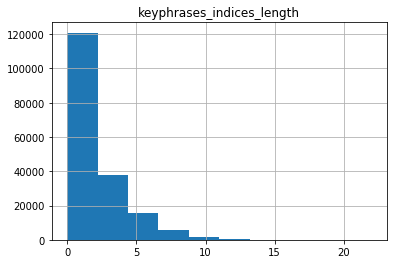

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

cur_df.hist(column='keyphrases_indices_length')

In [65]:
key_vector_index_list = [item for sublist in cur_df["keyVector"].values for item in sublist]
unique, counts = np.unique(key_vector_index_list, return_counts=True)
[(x, count) for count, x in sorted(zip(counts,keyphrases), key=lambda pair: pair[0], reverse=True)]

[('rock', 62089),
 ('pop', 35948),
 ('rap', 23092),
 ('metal', 22767),
 ('drum', 21345),
 ('ballad', 19002),
 ('blue', 18508),
 ('bass', 16691),
 ('instrument', 16675),
 ('dance', 13247),
 ('chorus', 11682),
 ('jazz', 8653),
 ('disco', 8615),
 ('funk', 8521),
 ('punk', 7830),
 ('folk', 7617),
 ('hiphop', 7567),
 ('hardrock', 7499),
 ('r b', 7492),
 ('concert', 6988),
 ('vocalist', 5426),
 ('soundtrack', 5369),
 ('electro', 4934),
 ('progressive', 4886),
 ('orchestra', 4229),
 ('classicrock', 3145),
 ('techno', 3099),
 ('grunge', 2715),
 ('classical', 2701),
 ('chant', 2674),
 ('psychedelic', 2435),
 ('gospel', 2219),
 ('reggae', 1928),
 ('opera ', 1731),
 ('indie', 1491),
 ('industrial', 1490),
 ('musicvideo', 1420),
 ('christian', 1267),
 ('ambient', 1182),
 ('countrymusic', 1173)]

In [66]:
cur_df['UserIndex'] = cur_df[USER_ID].astype('category').cat.rename_categories(range(0, cur_df[USER_ID].nunique()))
cur_df['ItemIndex'] = cur_df[ITEM_ID].astype('category').cat.rename_categories(range(0, cur_df[ITEM_ID].nunique()))
cur_df['Binary'] = (cur_df[RATING] > 3)*1

df_user_name = cur_df[['UserIndex',USER_ID]]
df_item_name = cur_df[['ItemIndex',ITEM_ID]]

total_review = len(cur_df)

print("Number of User: {0}".format(df_user_name['UserIndex'].nunique()))
print("Number of Item: {0}".format(df_item_name['ItemIndex'].nunique()))
print("Number of Positive Review: {0}".format(sum(cur_df['Binary'].tolist())))
print("Number of key Phrase: {0}".format(len(df_keyphrases)))
print("Number of reviews: {0}".format(total_review))

Number of User: 6056
Number of Item: 4395
Number of Positive Review: 152670
Number of key Phrase: 40
Number of reviews: 182503


In [67]:
dataPath = 'data/CDsVinyl/'

cur_df.to_csv(dataPath+'Data.csv')
df_word_index.to_csv(dataPath+'WordIndex.csv')
df_keyphrases.to_csv(dataPath+'KeyPhrases.csv')
df_user_name.to_csv(dataPath+'UserIndex.csv')
df_item_name.to_csv(dataPath+'ItemIndex.csv')

# Test Case

In [66]:
from nltk.util import ngrams

def check_bigram(w):
#     bigram = list(ngrams(token, 2))
    bigram = list(ngrams(nltk.word_tokenize(w), 2)) 
    if ("r", "b") in bigram:
        return 1
    else:
        return 0

In [67]:
cur_df["bigram"] = cur_df["conca_review"].apply(check_bigram)

/home/kai/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: generator 'ngrams' raised StopIteration
  """


In [68]:
cur_df["bigram"].sum()

7624

In [743]:
cur_df[cur_df["bigram"] == 1].index.values

array([   174,    206,    475, ..., 182394, 182423, 182427])

In [328]:
("r", "b") in list(ngrams(nltk.word_tokenize(cur_df["conca_review"].values[0]), 2)) 

False

In [316]:
token = nltk.word_tokenize(r_amp_b_df["conca_review"].values[1321])
bigram = list(ngrams(token, 2)) 

In [319]:
("r", "b") in bigram

True

In [42]:
r_amp_b_df = cur_df[cur_df.conca_review.str.contains('r b', regex=False)]
len(r_amp_b_df)

61633

In [750]:
r_amp_b_df.index.values

array([    16,     23,     91, ..., 182437, 182447, 182453])

In [751]:
from functools import reduce

len(reduce(np.union1d, (cur_df[cur_df["bigram"] == 1].index.values, r_amp_b_df.index.values)))

14096

In [428]:
np.setdiff1d(cur_df[cur_df["bigram"] == 1].index.values,r_amp_b_df.index.values)

array([ 10607,  11316,  29583,  29911,  30168,  30174,  41226,  48281,
        59439,  66666,  68280,  84550,  85820,  89251,  92612,  94862,
        99843, 101653, 103147, 104605, 112424, 120676, 120963, 128501,
       131605, 131629, 136178, 136678, 138502, 141313, 149751, 153518,
       154202, 154253, 157144, 159270, 166470, 166476, 168522, 169255,
       170122, 172700, 178329, 178334, 179759, 181418, 181939])

In [752]:
cur_df.iloc[16, :]["conca_review"]

' film year old came also german movie came three year ago forgotten movie still thrives frequently find great movie list critic fact way heard roger ebert great movie great movie opinion entertaining film though great movie one first first serial killer movie got good cinematography heard previous release film dvd vhs think got lucky copy obtained subtitle clear sound quality good picture right picture far perfect watchable film peter lorre may remember casablanca among thing play semi main character han beckert say semi main character character entire film built miraculously small amount screen time get right han beckert serial killer hinted pedophile also say back cover assume someone could go get lorre bring future every hollywood director making film serial killer would cast bug eyed creepy looking dude fit part well beginning film hover kid play game game typical child game word chant little sinister expect minute later one girl kidnapped killed record murder ever seen onscreen n

In [527]:
cur_df.iloc[1993, :][REVIEW_TEXT]

'Let\'s get one thing straight-I\'ve been listening to THE DOORS since the band\'s beginning-both live and on record.  So please don\'t think I dislike the band or their music when you read the following.  The four "stars" are for the original album.  I still own the original vinyl release-the one with the cool, clear plastic over the portrait of the band-along with all the other Elektra Records albums.Well-here it is I guess.  The original album plus about 51 minutes of previously unreleased alternate tracks.  Plus the unheard song "She Smells So Nice" (with a poorly recorded vocal).  Plus some between takes studio chat.  A booklet with a few photos of the band working in the studio, plus an essay by noted writer David Fricke.  All in a cardboard tri-fold package.  The sound is very good-even having a little warmth to it, reminiscent of the original vinyl release.Was "L.A. Woman" THE DOORS\' greatest album?  Maybe, maybe not.  Certainly it\'s one of the band\'s best albums.  And while

In [353]:
r_amp_b_df[REVIEW_TEXT].values[0]

"All the big UK and USA hits are hereThis group combined elements of pop, rock, blues and R+B in their music and you can hear all the different influences here. For example, I put a spell on you is a great piece of blues-rock, but Proud Mary is raw rock'n'roll.As far as hits are concerned, the group were more consistently successful in America than in Britain. In America, they had many big hits including several that peaked at number two without ever achieving a number one hit. In Britain, their overall record was more modest although they clocked up four top ten hits - and Bad moon rising went all the way to number one. Their other UK top ten hits were Proud Mary, Travelling band and Up around the bend (which made the top three).Among the other classic songs here are Green river, Down on the corner, Fortunate son, Who'll stop the rain, Looking out the back door, Long as I can see the light and Have you ever seen the rain. All of these were either huge American hits, or were B-sides of

In [360]:
r_amp_b_df[REVIEW_TEXT].values[78]

'Although, the beats on this Cd are typical RB, Fantasia\'s voice and singing style makes the ordinary R&B;  sound extraordinary.The songs are bit more "grimey" than those of her previous CD; more "street".  I like it!!Fantasia definately has talent. Finding the true style that fits her voice may take a minute, but for now I am enjoying her efforts.I will keep this CD on my MP3 player for a while.My favorite song is uneligble- with its all too true lyrics and the beat is bumping!!'

In [363]:
r_amp_b_df["review"].values[78]

['although',
 'beat',
 'cd',
 'typical',
 'rb',
 'fantasia',
 'voice',
 'singing',
 'style',
 'make',
 'ordinary',
 'r',
 'b',
 'sound',
 'extraordinary',
 'song',
 'bit',
 'grimey',
 'previous',
 'cd',
 'street',
 'like',
 'fantasia',
 'definately',
 'talent',
 'finding',
 'true',
 'style',
 'fit',
 'voice',
 'may',
 'take',
 'minute',
 'enjoying',
 'effort',
 'keep',
 'cd',
 'player',
 'favorite',
 'song',
 'uneligble',
 'true',
 'lyric',
 'beat',
 'bumping']

In [364]:
tmp = [x.replace("rb", " r b ") for x in r_amp_b_df["review"].values[78]]
tmp = " ".join(str(x) for x in tmp)
nltk.word_tokenize(tmp)

['although',
 'beat',
 'cd',
 'typical',
 'r',
 'b',
 'fantasia',
 'voice',
 'singing',
 'style',
 'make',
 'ordinary',
 'r',
 'b',
 'sound',
 'extraordinary',
 'song',
 'bit',
 'grimey',
 'previous',
 'cd',
 'street',
 'like',
 'fantasia',
 'definately',
 'talent',
 'finding',
 'true',
 'style',
 'fit',
 'voice',
 'may',
 'take',
 'minute',
 'enjoying',
 'effort',
 'keep',
 'cd',
 'player',
 'favorite',
 'song',
 'uneligble',
 'true',
 'lyric',
 'beat',
 'bumping']

In [334]:
r_amp_b_df[REVIEW_TEXT].values[1321]

"Bobby Brown,a member of New Edition,began his solo career in 1986 when the group released their fourth album UNDER THE BLUE MOON. Whitney Houston's future husband put out his debut hit GIRLFRIEND that year,and it sure does have the New Edition sound. With his second solo release,this album,Brown catapulted to superstardom. Hits from this album include DON'T BE CRUEL(not the Elvis Presley-Cheap Trick hit),RONI,MY PREROGATIVE and ROCK WIT'CHA. In 1988,when this album was released,New Edition released their fifth album HEARTBREAK. When Brown departed the group,his shoes were filled by Johnny Gill,who had a few pre-NE hits like PERFECT COMBINATION with Stacy Lattisaw. In addition to NE,Brown's MCA Records labelmates include Elton John,Tom Petty,The Jets and Patti LaBelle. Brown's fellow NE member Ralph Tresvant would pursue a solo career as well and the other three members Ricky Bell,Michael Bivins and Ronnie Devoe would spin themselves off as Bell Biv Devoe. Boston native Brown married H

In [312]:
r_amp_b_df["conca_review"].values[1321]

' thirty minute music fab four made transition mere genius legend cementing status one maybe even influental creative band time hear revolver question one diverse experimental entertaining original provocative musically competent album time spanning multidudes style recording technique lyrical theme frequently course album beatles rekindle early love r b spirited rocker taxman docter robert bird sing point experiment orchestral violen ballad elenor rigby delve phsycadelia track like said said sleeping absolutely stunning tomorrow never know seemingly fun mix horn violens whole orchestra song sleeping feature bckwards guitar solo tomorrow never know contains random snippits haphazardly mixed together creating excellent trippy environment song love feature sitar played george harrison imagery song boosted superb studio technique employment echo fuzz bass giving song dreamy energetic quality revolver brilliant experimental record hear believe listen trust love '

In [291]:
r_amp_b_df["review"].values[1321]

['first',
 'time',
 'heard',
 'played',
 'nt',
 'touch',
 'couple',
 'month',
 'much',
 'played',
 'went',
 'good',
 'god',
 'okay',
 'instrumental',
 'know',
 'like',
 'nail',
 'blackboard',
 'none',
 'frank',
 'hilarious',
 'observation',
 'nt',
 'let',
 'throw',
 'su',
 'pyg',
 'two',
 'hour',
 'sheer',
 'brilliance',
 'frank',
 'underrated',
 'guitar',
 'work',
 'hard',
 'pick',
 'one',
 'size',
 'fit',
 'desert',
 'island',
 'classic',
 'hmmmm',
 'well',
 'frank',
 'great',
 'humorist',
 'composer',
 'came',
 'sheer',
 'magnificence',
 'brilliance',
 'guitar',
 'work',
 'admittedly',
 'music',
 'snob',
 'guitaristwannabe',
 'sheer',
 'musicianship',
 'displayed',
 'su',
 'pyg',
 'surpassed',
 'wry',
 'humorous',
 'observation',
 'album',
 'apostrophe',
 'overnite',
 'sensation',
 'one',
 'size',
 'zoot',
 'allure',
 'album',
 'made',
 'lather',
 'set',
 'including',
 'live',
 'new',
 'york',
 'always',
 'mixed',
 'humorous',
 'musical',
 'stripped',
 'restraint',
 'lyric',
 'build

In [150]:
r_amp_b_df[REVIEW_TEXT].values[0].replace('.',' ').replace('/',' ').replace('&quot;', '"').replace('amp;', '')

'Since the first production of J M  Barrie\'s play, PETER PAN, in 1904, the story of the boy who never grew up has become a part of popular Western culture   It\'s a story that children love and that adults often adore   It even coined a sociological phrase (Peter Pan syndrome)   The play has been performed on stages throughout the world and to this day it remains one of the most popular shows performed in children\'s theatre companies   It shouldn\'t be a surprise to anyone that Peter Pan was one of Walt Disney\'s favorite stories of all time   He starred in a school production of the play as a child and the 1924 silent movie of the story sparked the imagination of the young filmmaker Walt Disney had intended to make PETER PAN his second major animation production after SNOW WHITE   However, it took many years to get the look right and to adapt the story (Disney, after all, was a master of taking a story and changing it and creating it to his own liking)   Of course, there was also WW

In [232]:
text = "Hip&Hop"
text = text.replace('.',' ').replace('/',' ').replace('quot;', ' ').replace('amp;', '')
print("text after replace {}".format(text))

# Process ReviewText
text = nltk.word_tokenize(text)+[' ']
print("text after tokenize {}".format(text))

# Lowercase
text = [w.lower() for w in text]
print("text after lower {}".format(text))

# Remove Punctuation
table = str.maketrans('', '', string.punctuation)
text = [w.translate(table) for w in text]
print("text after removing punctuation {}".format(text))

# Remove tokens that are not alphabetic
text = [w for w in text if w.isalpha()]
print("text after removing non-alphabetic {}".format(text))

# Remove Stopwords
# Get english stopwords
en_stopwords = set(stopwords.words('english'))
text = [w for w in text if w not in en_stopwords]
print("text after removing stopwords {}".format(text))
    
# Lemmatizing
lemmatizer = WordNetLemmatizer()
text = [lemmatizer.lemmatize(w) for w in text]
print("text after removing lemmatization {}".format(text))

text after replace Hip&Hop
text after tokenize ['Hip', '&', 'Hop', ' ']
text after lower ['hip', '&', 'hop', ' ']
text after removing punctuation ['hip', '', 'hop', ' ']
text after removing non-alphabetic ['hip', 'hop']
text after removing stopwords ['hip', 'hop']
text after removing lemmatization ['hip', 'hop']


In [169]:
text = "R+B"
text = text.replace('.',' ').replace('/',' ').replace('quot;', ' ').replace('amp;', '').replace('+', ' ')
print("text after replace {}".format(text))

# Process ReviewText
text = nltk.word_tokenize(text)+[' ']
print("text after tokenize {}".format(text))

# Lowercase
text = [w.lower() for w in text]
print("text after lower {}".format(text))

# Remove Punctuation
table = str.maketrans('', '', string.punctuation)
text = [w.translate(table) for w in text]
print("text after removing punctuation {}".format(text))

# Remove tokens that are not alphabetic
text = [w for w in text if w.isalpha()]
print("text after removing non-alphabetic {}".format(text))

# Remove Stopwords
# Get english stopwords
en_stopwords = set(stopwords.words('english'))
text = [w for w in text if w not in en_stopwords]
print("text after removing stopwords {}".format(text))
    
# Lemmatizing
lemmatizer = WordNetLemmatizer()
text = [lemmatizer.lemmatize(w) for w in text]
print("text after removing lemmatization {}".format(text))

text after replace R B
text after tokenize ['R', 'B', ' ']
text after lower ['r', 'b', ' ']
text after removing punctuation ['r', 'b', ' ']
text after removing non-alphabetic ['r', 'b']
text after removing stopwords ['r', 'b']
text after removing lemmatization ['r', 'b']


In [272]:
cur_df[cur_df["review"].str.contains('rb', regex=False)][REVIEW_TEXT].values[0]

"All the big UK and USA hits are hereThis group combined elements of pop, rock, blues and R+B in their music and you can hear all the different influences here. For example, I put a spell on you is a great piece of blues-rock, but Proud Mary is raw rock'n'roll.As far as hits are concerned, the group were more consistently successful in America than in Britain. In America, they had many big hits including several that peaked at number two without ever achieving a number one hit. In Britain, their overall record was more modest although they clocked up four top ten hits - and Bad moon rising went all the way to number one. Their other UK top ten hits were Proud Mary, Travelling band and Up around the bend (which made the top three).Among the other classic songs here are Green river, Down on the corner, Fortunate son, Who'll stop the rain, Looking out the back door, Long as I can see the light and Have you ever seen the rain. All of these were either huge American hits, or were B-sides of

In [273]:
cur_df[cur_df["review"].str.contains('rb', regex=False)]["review"].values[0]

['big',
 'uk',
 'usa',
 'hit',
 'herethis',
 'group',
 'combined',
 'element',
 'pop',
 'rock',
 'blue',
 'rb',
 'music',
 'hear',
 'different',
 'influence',
 'example',
 'put',
 'spell',
 'great',
 'piece',
 'bluesrock',
 'proud',
 'mary',
 'raw',
 'rocknroll',
 'far',
 'hit',
 'concerned',
 'group',
 'consistently',
 'successful',
 'america',
 'britain',
 'america',
 'many',
 'big',
 'hit',
 'including',
 'several',
 'peaked',
 'number',
 'two',
 'without',
 'ever',
 'achieving',
 'number',
 'one',
 'hit',
 'britain',
 'overall',
 'record',
 'modest',
 'although',
 'clocked',
 'four',
 'top',
 'ten',
 'hit',
 'bad',
 'moon',
 'rising',
 'went',
 'way',
 'number',
 'one',
 'uk',
 'top',
 'ten',
 'hit',
 'proud',
 'mary',
 'travelling',
 'band',
 'around',
 'bend',
 'made',
 'top',
 'three',
 'among',
 'classic',
 'song',
 'green',
 'river',
 'corner',
 'fortunate',
 'son',
 'stop',
 'rain',
 'looking',
 'back',
 'door',
 'long',
 'see',
 'light',
 'ever',
 'seen',
 'rain',
 'either',

In [173]:
r_b_df = cur_df[cur_df.conca_review.str.contains('r b', regex=False)]
r_b_df.head()

,reviewerID,asin,overall,unixReviewTime,reviewText,Binary,review,conca_review,keyVector,keyphrases_indices_length,UserIndex,ItemIndex
1,ANCOMAI0I7LVG,0780018664,5.0,1213574400,My feelings for this iconic piece of filmmakin...,1,"[feeling, iconic, piece, filmmaking, mirror, p...",feeling iconic piece filmmaking mirror previou...,"[13, 14, 17, 29, 47, 47]",6,5481,0
2,A1GGOC9PVDXW7Z,0780018664,5.0,1268524800,The title M comes from a chalk mark (for 'murd...,1,"[title, come, chalk, mark, murderer, placed, b...",title come chalk mark murderer placed beggar b...,"[13, 14, 29, 54]",4,758,0
3,A62G4QX6XQVLP,0780018664,5.0,1165190400,This film is easily in the Top 5 of Fritz Lang...,1,"[film, easily, top, fritz, lang, best, film, q...",film easily top fritz lang best film quite pos...,"[13, 14, 29, 54, 59]",5,4782,0
6,AIMR915K4YCN,0780018664,5.0,1083196800,"While watching this story unfold, I found myse...",1,"[watching, story, unfold, found, quite, roller...",watching story unfold found quite rollercoaste...,"[13, 29]",2,5301,0
8,A2C7BOQVFH1HLE,0780018664,4.0,1302825600,This is the first Criterion release that I've ...,1,"[first, criterion, release, ever, seen, say, q...",first criterion release ever seen say quite im...,"[13, 14, 17, 29, 30]",5,2171,0


In [174]:
r_b_df[REVIEW_TEXT].values[1321]

"A rock opera is something that Frank Zappa would be a perfect artist for.  His albums are usually strung together in some way, he loves putting in all these characters, and a lot of his songs are about stories.  This album works very well.  It includes Frank Zappa's goofiness, and his musical talent.  The story is basically the story of all of the things that happen if you choose a career in music... at least in some sort of future.Just about each track begins with an introduction from the Central Scrutinizer, who is basically just the narrator, performed by Frank Zappa, whispering through a plastic megaphone.  Frank Zappa also portrays a few other characters, the first one that comes to mind is Joe's best friend who betrays him.  Ike Willis portrays the star of the album, Joe.  Joe starts out as a young teenager in a garage band.  The story is a very weird and sometimes confusing story that doesn't end the way that anyone who buys this album would consider a happy ending, but the end

In [175]:
r_b_df["review"].values[1321]

['rock',
 'opera',
 'something',
 'frank',
 'zappa',
 'would',
 'perfect',
 'artist',
 'album',
 'usually',
 'strung',
 'together',
 'way',
 'love',
 'putting',
 'character',
 'lot',
 'song',
 'story',
 'album',
 'work',
 'well',
 'includes',
 'frank',
 'zappa',
 'goofiness',
 'musical',
 'talent',
 'story',
 'basically',
 'story',
 'thing',
 'happen',
 'choose',
 'career',
 'music',
 'least',
 'sort',
 'future',
 'track',
 'begin',
 'introduction',
 'central',
 'scrutinizer',
 'basically',
 'narrator',
 'performed',
 'frank',
 'zappa',
 'whispering',
 'plastic',
 'megaphone',
 'frank',
 'zappa',
 'also',
 'portrays',
 'character',
 'first',
 'one',
 'come',
 'mind',
 'joe',
 'best',
 'friend',
 'betrays',
 'ike',
 'willis',
 'portrays',
 'star',
 'album',
 'joe',
 'joe',
 'start',
 'young',
 'teenager',
 'garage',
 'band',
 'story',
 'weird',
 'sometimes',
 'confusing',
 'story',
 'nt',
 'end',
 'way',
 'anyone',
 'buy',
 'album',
 'would',
 'consider',
 'happy',
 'ending',
 'ending',

# Work on reviews without tag

In [68]:
tokenizer = Tokenizer()
token_list = cur_df[cur_df["keyphrases_indices_length"] == 0]["review"].tolist()
tokenizer.fit_on_texts(token_list)

In [69]:
df_word_index = pd.DataFrame(list(tokenizer.word_index.items()), columns=['word','index'])

In [70]:
df_word_index

,word,index
0,album,1
1,song,2
2,nt,3
3,one,4
4,cd,5
5,like,6
6,great,7
7,good,8
8,music,9
9,best,10


In [71]:
token_flatten_list = [item for sublist in token_list for item in sublist]

In [72]:
total_token = len(token_flatten_list)
total_token

2306116

In [73]:
from nltk.probability import FreqDist

fdist2 = FreqDist(token_flatten_list)

In [74]:
fdist2.most_common(250)

[('album', 67546),
 ('song', 50113),
 ('nt', 30293),
 ('one', 28739),
 ('cd', 28633),
 ('like', 27394),
 ('great', 21485),
 ('good', 21293),
 ('music', 17220),
 ('best', 15584),
 ('track', 15309),
 ('love', 14241),
 ('time', 13941),
 ('sound', 13221),
 ('get', 13159),
 ('really', 13057),
 ('first', 11432),
 ('band', 11227),
 ('fan', 10464),
 ('would', 10246),
 ('still', 9085),
 ('well', 8806),
 ('much', 8450),
 ('better', 8371),
 ('hit', 8181),
 ('new', 8089),
 ('think', 7982),
 ('year', 7963),
 ('make', 7697),
 ('listen', 7681),
 ('even', 7625),
 ('favorite', 7199),
 ('say', 7155),
 ('know', 6654),
 ('way', 6622),
 ('also', 6412),
 ('back', 6303),
 ('buy', 6234),
 ('many', 6217),
 ('voice', 6109),
 ('ever', 6040),
 ('go', 6037),
 ('lyric', 5983),
 ('could', 5774),
 ('heard', 5759),
 ('every', 5701),
 ('never', 5668),
 ('work', 5561),
 ('collection', 5420),
 ('record', 5409),
 ('two', 5325),
 ('thing', 5299),
 ('come', 5216),
 ('release', 5187),
 ('classic', 5160),
 ('day', 5153),
 ('s

In [75]:
bigrams = nltk.collocations.BigramAssocMeasures()
tokens = itertools.chain.from_iterable(token_list)
bigramFinder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
bigramFinder.apply_freq_filter(100)

bigram_freq = bigramFinder.ngram_fd.items()
bigramFreqTable = pd.DataFrame(list(bigram_freq), 
                               columns=['ngram','freq']).sort_values(by='freq', ascending=False)

In [76]:
bigramFreqTable[:50]

,ngram,freq
26,"(ca, nt)",4082
87,"(one, best)",2451
402,"(song, album)",2319
140,"(great, song)",2232
98,"(sound, like)",2146
141,"(song, like)",2108
281,"(best, album)",2068
163,"(every, song)",1955
556,"(greatest, hit)",1951
233,"(great, album)",1947


In [77]:
bigramFreqTable[bigramFreqTable.ngram.map(lambda x: filter_type(x))]

,ngram,freq
140,"(great, song)",2232
281,"(best, album)",2068
556,"(greatest, hit)",1951
233,"(great, album)",1947
469,"(good, song)",1942
420,"(best, song)",1937
682,"(good, album)",1347
231,"(song, cd)",1138
95,"(first, time)",924
326,"(great, cd)",882


In [78]:
bigramFinder.apply_freq_filter(100)
bigramPMITable = pd.DataFrame(list(bigramFinder.score_ngrams(bigrams.pmi)), 
                              columns=['bigram','PMI']).sort_values(by='PMI', ascending=False)

bigramPMITable

,bigram,PMI
0,"(limp, bizkit)",13.606034
1,"(marvin, gaye)",13.568393
2,"(biting, bleedingim)",13.522324
3,"(bleedingim, biting)",13.522324
4,"(bee, gee)",13.348757
5,"(bon, jovi)",13.323820
6,"(dire, strait)",13.205964
7,"(joni, mitchell)",13.184012
8,"(depeche, mode)",13.067906
9,"(steely, dan)",13.050533


In [79]:
bigramPMITable = bigramPMITable[bigramPMITable.bigram.map(lambda x: filter_type(x))]
bigramPMITable

,bigram,PMI
32,"(eric, clapton)",11.605099
49,"(brian, wilson)",10.831610
57,"(mary, j)",10.484388
59,"(deluxe, edition)",10.432283
66,"(american, idol)",10.276688
69,"(limited, edition)",10.163207
71,"(subject, matter)",9.997092
76,"(deep, purple)",9.867494
82,"(ok, computer)",9.601045
87,"(top, notch)",9.469580


In [80]:
trigrams = nltk.collocations.TrigramAssocMeasures()
tokens = itertools.chain.from_iterable(token_list)
trigramFinder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
trigram_freq = trigramFinder.ngram_fd.items()

trigramFreqTable = pd.DataFrame(list(trigram_freq), 
                                columns=['ngram','freq']).sort_values(by='freq', ascending=False)

In [81]:
trigramFreqTable = trigramFreqTable[trigramFreqTable["freq"] >= 10]

In [82]:
trigramFreqTable

,ngram,freq
8420,"(one, best, album)",509
16583,"(greatest, hit, album)",333
24995,"(nt, get, wrong)",322
45026,"(ca, nt, get)",304
16753,"(best, song, album)",297
8828,"(ca, nt, wait)",291
21409,"(dark, side, moon)",256
8856,"(best, album, ever)",245
24146,"(one, best, song)",226
19914,"(every, song, album)",223
